## This notebook generates LOS models for NH facilityfacts files ##

In [1]:
import os
from collections import defaultdict
import pandas as pd
from IPython.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, lognorm
import scipy.optimize as op
from stats import fullCRVFromPDFModel, CachedCDFGenerator
import tools_util as tu
import pyrheautils as pu

## Load the model ##

In [2]:
runDesc = '/home/welling/git/pyRHEA_github/src/sim/twoyear_allfac_OC.yaml'
inputDict = tu.readModelInputs(runDesc)
pu.prepPathTranslations(inputDict)
facDict = tu.getFacDict(inputDict)


## Load the line list data ##

In [3]:
lineDF = pd.read_csv(pu.pathTranslate('$(MODELDIR)/'
                                     'OC_Nursing_Home_LOS_Line-Lists_for_RHEA_2.0_-_2011-2015_-_Adult_Only_-_06-10-2019_UPDATE_NH_LOS_Line_List.csv'))

#                                      'OC_Nursing_Home_LOS_Line-Lists_for_RHEA_2.0_-_2011-2015_-_Adult_Only_-_05-21-2019_UPDATE_v2_NH_LOS_Line_List.csv'))
print lineDF.columns
lineDF = lineDF[lineDF['NOT YET DISCHARGED?'].isnull()]
display(lineDF.head())

Index([u'NH CODE', u'DISCHARGE/ASSESSMENT YEAR', u'RAW LOS (days)',
       u'NOT YET DISCHARGED?', u'ADD 45 DAYS?', u'ADJUSTED LOS (days)'],
      dtype='object')


,NH CODE,DISCHARGE/ASSESSMENT YEAR,RAW LOS (days),NOT YET DISCHARGED?,ADD 45 DAYS?,ADJUSTED LOS (days)
0,ALAM,2012,12,NaN,NaN,12
1,ALAM,2012,19,NaN,NaN,19
2,ALAM,2014,10,NaN,NaN,10
3,ALAM,2012,41,NaN,NaN,41
4,ALAM,2011,5,NaN,NaN,5


## Some Useful Functions ##

Also, make the plots big enough to see

In [4]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
#plt.rcParams["figure.figsize"] = [16, 10]
plt.rcParams["figure.figsize"] = [8, 5]

In [5]:
def pltCRV(crv, scale=1.0, label=None, xlim=None):
    mv = crv.mean()
    if xlim is None:
        xV = np.linspace(0.0, round(3*mv), 101)
    else:
        xV = np.linspace(0.0, xlim, 101)
    yV = scale * crv.pdf(xV)
    if label is None:
        plt.plot(xV, yV, '-')
    else:
        plt.plot(xV, yV, '-', label=label)
    plt.plot([mv], [0.0], '*')
    print mv


['SEAC' 'ACNC' 'SCRT' 'VICT' 'SEAC']
35.86473110166598


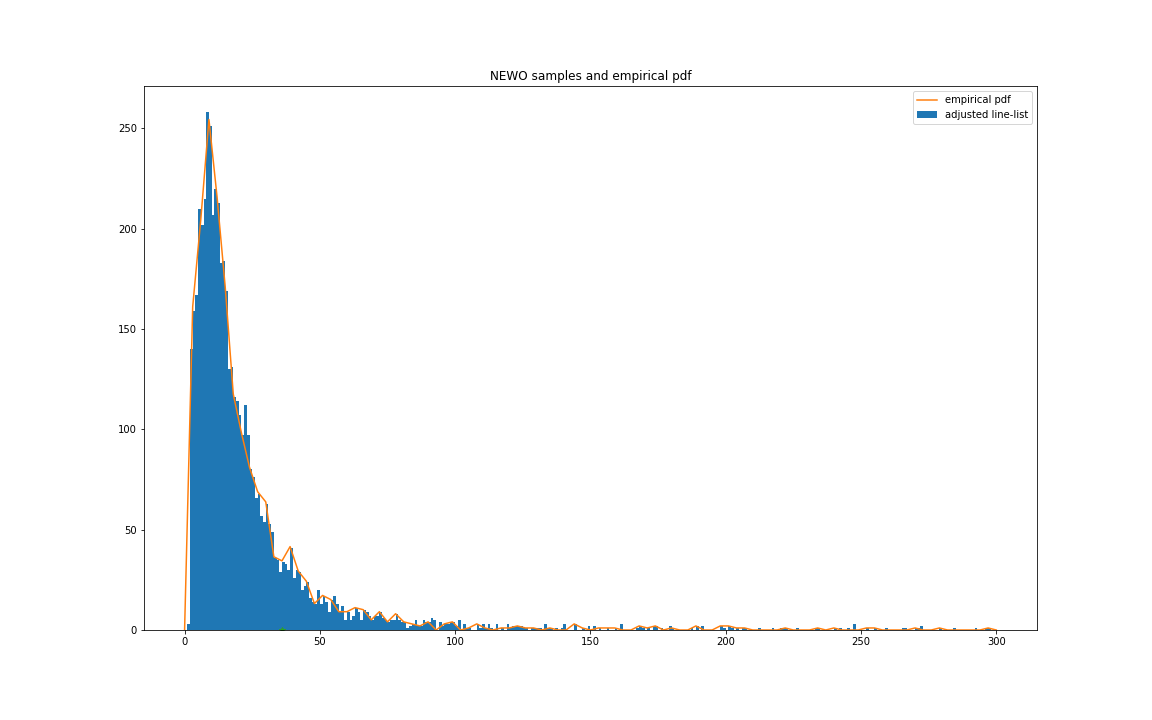

In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%matplotlib inline
plt.rcParams["figure.figsize"] = [16, 10]

showL = np.random.choice([abbrev for abbrev, rec in facDict.items() if rec['category'] == 'NURSINGHOME'], size=5)
print showL
showL = ['NEWO']
for abbrev in showL:
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    histoD = defaultdict(int)
    for idx, row in facLOSDF.iterrows():
        los = int(row['ADJUSTED LOS (days)'])
        histoD[los] += 1
    losModel = {'pdf': 'empirical(loc=$0,scale=$1)',
               'prov': 'experiment',
               'parms': [0.0, 1.0],
               'sampleHistogram': histoD}
    crv = fullCRVFromPDFModel(losModel)
    plt.hist(facLOSDF['RAW LOS (days)'], range=(0,300), bins=300, label='adjusted line-list')
    nLines = facLOSDF.count()['NH CODE']
    pltCRV(crv, scale=nLines/crv.cdf(365.), label='empirical pdf', xlim=300)
    plt.legend()
    #plt.title('%s %s' % (abbrev, fitLOSModel['parms']))
    plt.title('%s samples and empirical pdf' % abbrev)
    plt.show()


35.86473110166598


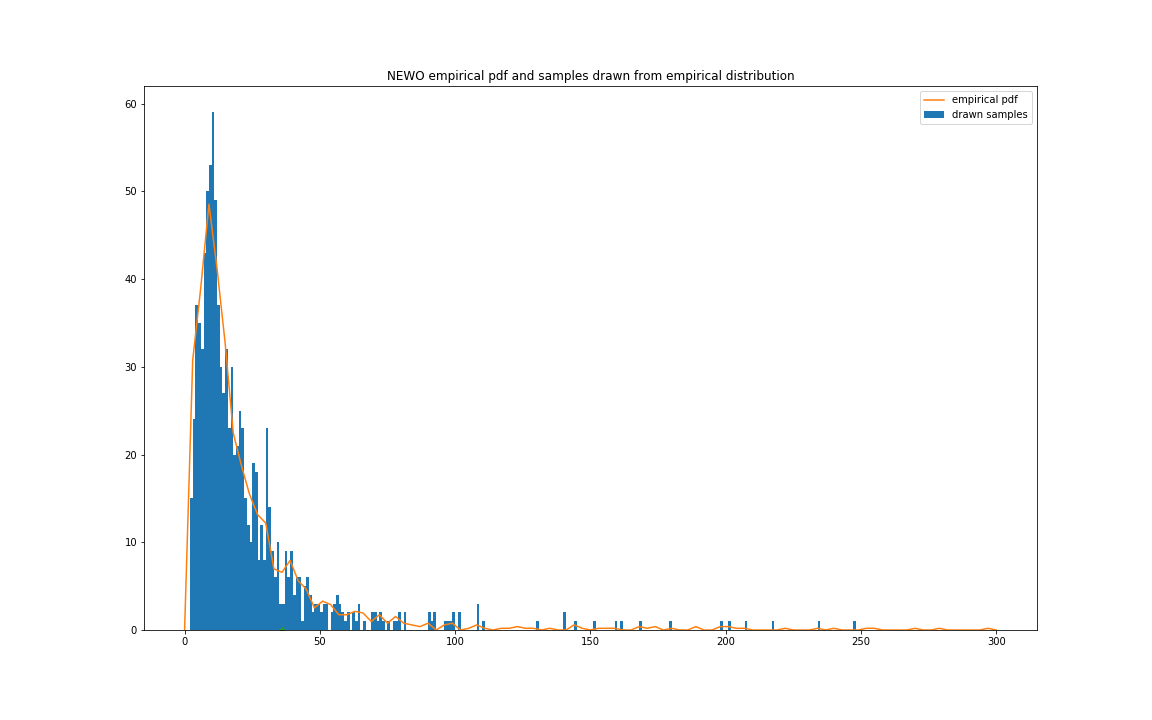

In [13]:

for abbrev in showL:
    facLOSDF = lineDF[lineDF['NH CODE'] == abbrev]
    histoD = defaultdict(int)
    for idx, row in facLOSDF.iterrows():
        los = int(row['ADJUSTED LOS (days)'])
        histoD[los] += 1
    losModel = {'pdf': 'empirical(loc=$0,scale=$1)',
               'prov': 'experiment',
               'parms': [0.0, 1.0],
               'sampleHistogram': histoD}
    crv = fullCRVFromPDFModel(losModel)
    nsamps = 1000
    plt.hist(crv.rvs(size=nsamps), range=(0,300), bins=300, label='drawn samples')
    pltCRV(crv, scale=nsamps/crv.cdf(365.), label='empirical pdf', xlim=300)
    plt.legend()
    #plt.title('%s %s' % (abbrev, fitLOSModel['parms']))
    plt.title('%s empirical pdf and samples drawn from empirical distribution' % abbrev)
    plt.show()


## Save the fit models ##

In [ ]:
orecL = []
for abbrev, rec in fitD.items():
    orec = {('parms{}'.format(i)) : v for i, v in enumerate(rec['parms'])}
    orec.update({'abbrev': abbrev, 'pdf': rec['pdf'], 'nsamples': rec['nsamples'],
                 'chisqr_per_sample': rec['chisqr_per_sample']})
    orecL.append(orec)
odf = pd.DataFrame(orecL)
odf = odf.sort_values(['abbrev'], axis=0)
odf.to_csv('los_model_fit_nh_split_fates.csv', index=False)

## Read and plot intervalprob values captured by JournalingCachedCDFGenerator ##

In [ ]:
simDF = pd.read_msgpack(pu.pathTranslate('$(SIMDIR)/cdf_intervalprob_results.mpz'))
#display(simDF.head())
for abbrev in simDF['abbrev'].unique():
    print abbrev
    df = simDF[simDF.abbrev == abbrev]
    #display(df.head())
    for pdf in df['pdf'].unique():
        print pdf
        subDF = df[df.pdf == pdf]
        display(subDF.tail())
        plt.plot(0.5*(subDF['start'] + subDF['end']), subDF['rslt'], '*', alpha=0.01, label=pdf)
    plt.xlim(0.0, 300.0)
    plt.title(abbrev)
    plt.legend()
    plt.show()
    

## Some experiments in storing samples as yaml ##

In [ ]:
from collections import defaultdict
facLOSDF = lineDF[lineDF['NH CODE'] == 'NEWO']
sampDF = facLOSDF['RAW LOS (days)']
dct = defaultdict(int)
for elt in sampDF:
    dct[elt] += 1
dct = {k: v for k, v in dct.items()}
print dct

   

In [ ]:
#shortHS = pd.Series(losHV)
mystr = json.dumps(dct)
print 'length: ', len(mystr)
print mystr


In [ ]:
import json
dct = json.loads(mystr)
idct = {}
maxK = 0
for k, v in dct.items():
    ik = int(k)
    idct[ik] = v
    maxK = max(maxK, ik)
print maxK
print idct


In [ ]:
arr = np.zeros(maxK+1, dtype=np.int)
for k, v in idct.items():
    arr[k] = v
print len(arr)
print arr

In [ ]:
sumArr = np.cumsum(arr)
print len(sumArr)
print sumArr

In [ ]:
def intervalprob(day, sumArr):
    if day < len(sumArr):
        prevCt = 0 if day == 0 else sumArr[day-1]
        delta = sumArr[day] - prevCt
    else:
        prevCt = 0
        delta = 0
    return float(delta) / float(sumArr[-1] - prevCt)

In [ ]:
print intervalprob(37, sumArr)

In [ ]:
xV = np.arange(0.0, 300.0, 1.0)
yV = [intervalprob(int(x), sumArr) for x in xV]
plt.plot(xV, yV, '-')
plt.show()